In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import matplotlib.pyplot as plt
import time
from datetime import datetime
from SAEModel import SparseAutoencoder
from torch.nn import functional as F
import json
from collections import defaultdict
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from mistral_common.tokens.tokenizers.mistral import MistralTokenizer
from mistral_common.protocol.instruct.request import ChatCompletionRequest
from mistral_common.protocol.instruct.messages import UserMessage
from datasets import load_dataset
import numpy as np

from eval_utils import getDict, most_common_neurons, get_word_list

### Load SAE

In [67]:
if 'sae_model' in globals() and sae_model is not None:
    del sae_model
    torch.cuda.empty_cache()  # Clear the GPU memory

input_dim = 4096  # Input and output dimensions
hidden_dim = input_dim * 100  # Hidden layer dimension
K = 24

state_dict = torch.load("/workspace/LLM_interpretability/TopKSAE/experiments/100x_k_comparison_20241210_043339/mistral_pile_k24_experiment_20241210/models/model_epoch_30.pt")

# Load the weights into the model
sae_model = SparseAutoencoder(input_dim, hidden_dim, k = K, dead_steps_threshold=1000000) # initial lambda is 0
sae_model.load_state_dict(state_dict)
sae_model.to('cuda')

/tmp/ipykernel_633169/1931317415.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("/workspace/LLM_interpretability/TopKSAE/experiments/100x_k_comp

SparseAutoencoder()

## Modified Dataset to also return text with embedding for ease of visualisation

In [3]:

class EmbeddingDataset(Dataset):
    def __init__(self, path, file_pattern, use_files = 40):
        # Load all `.pt` files based on the pattern
        self.file_path = path
        self.files = sorted(glob.glob(path+"/"+file_pattern))
        print(f"Num of files found : {len(self.files)}")
        print(f"Num of files used : {len(self.files[:use_files])}")
        self.data = []

        # Read and store all embeddings from all files
        for file in self.files[:use_files]:
            batch_data = torch.load(file)
            # Extract embeddings and flatten them into a list
            self.data.extend([(item["embedding"], item["text"]) for item in batch_data])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [4]:
path = "/workspace/mistral_pile"
file_pattern = "*3.pt"  # Adjust the path if needed

pile_data = EmbeddingDataset(path, file_pattern , use_files=20)
pile_data_loader = DataLoader(pile_data, batch_size=1024, shuffle=True)
# If certain words evoke feature activations
pile_data_Dict = getDict(pile_data_loader, sae_model, K=K)

Num of files found : 14
Num of files used : 14


/tmp/ipykernel_633169/260067385.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_data = torch.load(file)
Processing Batches:   7%|▋         | 1/14 [00:00<00:09,  1

Processed Batch 0...


Processing Batches: 100%|██████████| 14/14 [00:08<00:00,  1.60it/s]


### Load LLM model 

In [ ]:
# Load Mistral
from dotenv import load_dotenv
load_dotenv()

# Retrieve the Hugging Face token
access_token = os.getenv("HF_TOKEN")
model_name = "mistralai/Mistral-7B-Instruct-v0.2"
model = AutoModelForCausalLM.from_pretrained(model_name, token=access_token, device_map="cuda")
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=access_token)

## Residual Hook Function
def gather_residual_activations(model, target_layer, inputs):
  target_act = None
  def gather_target_act_hook(mod, inputs, outputs):
    nonlocal target_act # make sure we can modify the target_act from the outer scope
    target_act = outputs[0]
    return outputs
  handle = model.model.layers[target_layer].register_forward_hook(gather_target_act_hook)
  _ = model.forward(inputs)
  handle.remove()
  return target_act

def get_word_vector_pairs(tokenizer_output, model_output):
    wordVectorPairs = []
    for i, word in enumerate(tokenizer_output):
        #print(i, word, tokenizer.decode(word), model_output[i, :].shape)
        wordVectorPairs.append({"text":tokenizer.decode(word), "embedding": model_output[i, :]})
    # print(wordVectorPairs)
    return wordVectorPairs


def prepare_batch_embeddings(text, tokenizer, model, gather_residual_activations, layer_index=16):

    inputs = tokenizer.encode(text, return_tensors="pt", add_special_tokens=False).to("cuda")
    
    with torch.no_grad():
        residuals = gather_residual_activations(model, layer_index, inputs)
    
    out = get_word_vector_pairs(inputs[0].cpu().tolist(), residuals[0].cpu())

    batch_text = [item["text"] for item in out]
    batch_embeddings = torch.stack([item["embedding"] for item in out])

    return batch_embeddings, batch_text



model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

/opt/conda/lib/python3.11/site-packages/transformers/models/auto/tokenization_auto.py:810: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

### Visualize Text

In [3]:
### Normalization present !!!
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib import cm
from IPython.display import HTML, display
import torch

def sentence_heatmap_visualization(batch_text, batch_embeddings, feature_index, sae_model):
    sae_model.eval()

    # Forward pass to get latent activations
    with torch.no_grad():
        _, _, _, latents = sae_model(batch_embeddings.cuda())

    # Per-token normalization
    latents_np = latents.cpu().numpy()  # Convert to numpy
    latents_min = latents_np.min(axis=-1, keepdims=True)  # Min per token
    latents_max = latents_np.max(axis=-1, keepdims=True)  # Max per token
    latents_normalized = (latents_np - latents_min) / (latents_max - latents_min + 1e-8)  # Normalize per token

    # Extract normalized activations for the given feature index
    feature_activations = latents_normalized[:, feature_index]

    # Create HTML with tokens highlighted
    sentence_html = ""
    # cmap = cm.get_cmap("Reds")

    blue_pastel_cmap = LinearSegmentedColormap.from_list(
        "blue_pastel", ["#D0E8F2", "#A9D6E5", "#89C2D9", "#61A5C2", "#468FAF"]
    )
    cmap = blue_pastel_cmap

    # Define transparency scaling factor (e.g., 0.7 for 70% transparency)
    alpha_scaling = 0.7

    for token, act in zip(batch_text, feature_activations):
        if act == 0 or np.isnan(act):  # Handle NaN values gracefully
            color_hex = "rgba(255, 255, 255, 0)"  # Fully transparent for zero activation
        else:
            color = cmap(act)
            color_hex = f"rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3] * alpha_scaling})"
        token = token.replace("<", "&lt;").replace(">", "&gt;")  # Sanitize tokens
        sentence_html += f'<span style="background-color: {color_hex}; padding: 2px 4px; margin: 2px; text-decoration: none;">{token}</span> '

    # Render HTML visualizations as a single paragraph
    html_visualization = f"<p style='font-family: monospace; text-decoration: none;'>{sentence_html}</p>"
    display(HTML(html_visualization))

    # Optional: Add a color scale (uncomment if needed)
    # fig, ax = plt.subplots(figsize=(6, 1))
    # fig.subplots_adjust(bottom=0.5)
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    # cbar = plt.colorbar(sm, orientation='horizontal', ax=ax)
    # cbar.set_label('Normalized Activation Strength (0 to 1)')
    # plt.show()


### Visualuze activation for certain text and feature_index

In [ ]:
# Feature to visualize
feature_index = 3597
text = "The suspect was caught red-handed. Police confirmed the stolen goods were recovered. Crime rates in the city have been steadily increasing."
batch_embeddings, batch_text = prepare_batch_embeddings(text, tokenizer, model, gather_residual_activations, layer_index=16)
batch_embeddings = batch_embeddings.to(torch.float32)
# Visualize the heatmap
sentence_heatmap_visualization(batch_text, batch_embeddings, feature_index, sae_model)


/tmp/ipykernel_445498/879806187.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


In [ ]:
# # Feature to visualize
# feature_index = 3597

# # Process a single batch from the DataLoader
# batch_embeddings, batch_text = next(iter(pile_data_loader))
# batch_embeddings = batch_embeddings.to(torch.float32)
# print(len(batch_text))
# # Visualize the heatmap
# sentence_heatmap_visualization(batch_text, batch_embeddings, feature_index, sae_model)


1024


/tmp/ipykernel_445498/879806187.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")


In [7]:
def latent_distribution(text, tokenizer, model, sae_model, gather_residual_activations, layer_index=16):
    # Prepare batch embeddings and text
    batch_embeddings, batch_text = prepare_batch_embeddings(text, tokenizer, model, gather_residual_activations, layer_index)
    batch_embeddings = batch_embeddings.to(torch.float32)

    # Forward pass through SAE model
    sae_model.eval()

    with torch.no_grad():
        _, _, _, latents = sae_model(batch_embeddings.cuda())
    latents = latents.cpu().numpy()
    
    print(f"Latents Shape: {latents.shape}")

    # Calculate min and max for the latents
    latents_min = latents.min()
    latents_max = latents.max()

    # Min-max normalization per token
    latents_normalized = (latents - latents.min(axis=-1, keepdims=True)) / (
        latents.max(axis=-1, keepdims=True) - latents.min(axis=-1, keepdims=True)
    )

    print(f"Latents Min: {latents_min}, Max: {latents_max}")
    latents = latents_normalized[2]
    non_zero_activations = latents[latents > 0]
    plt.figure(figsize=(10, 6))
    plt.hist(non_zero_activations, bins=20, color='blue', alpha=0.7, density=True)
    plt.title("Non-Zero Latent Activations Distribution")
    plt.xlabel("Activation Values")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()



### Activation strength Distribution

Latents Shape: (16, 409600)
Latents Min: 0.0, Max: 27.390993118286133


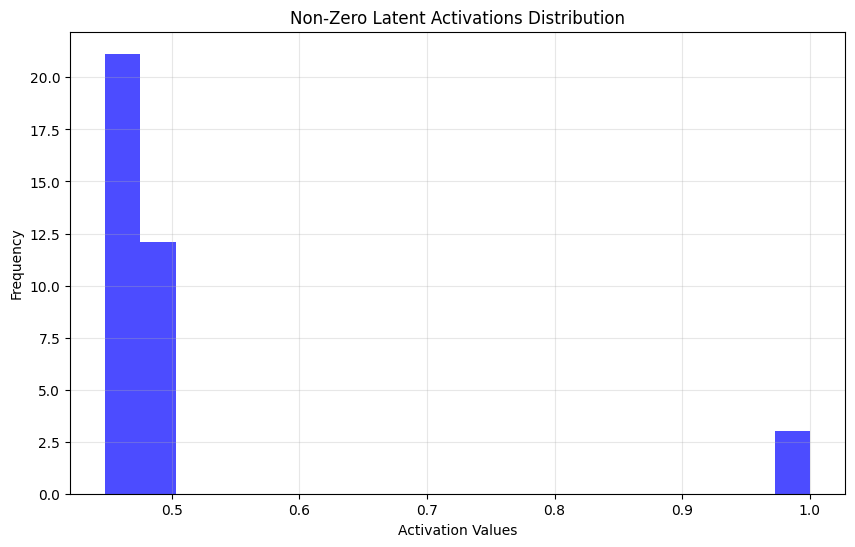

In [8]:
latent_distribution(
    text="The suspect was caught red-handed. Police confirmed the stolen goods were recovered.",
    tokenizer=tokenizer,
    model=model,
    sae_model=sae_model,
    gather_residual_activations=gather_residual_activations,
    layer_index=16,
)

### Text generation and grouping them

In [56]:
def sentence_heatmap_visualization_with_activations(batch_text, activations, feature_index, activation_threshold=0):
    # Extract normalized activations for the given feature index
    feature_activations = activations[:, feature_index]

    # Create HTML with tokens highlighted
    sentence_html = ""
    cmap = cm.get_cmap("Reds")

    # Define transparency scaling factor (e.g., 0.7 for 70% transparency)
    alpha_scaling = 0.7

    for token, act in zip(batch_text, feature_activations):
        # Skip tokens with activations below the threshold
        if act < activation_threshold or np.isnan(act):  # Handle NaN values gracefully
            color_hex = "rgba(255, 255, 255, 0)"  # Fully transparent for below-threshold activation
        else:
            color = cmap(act)
            color_hex = f"rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, {color[3] * alpha_scaling})"
        token = token.replace("<", "&lt;").replace(">", "&gt;")  # Sanitize tokens
        sentence_html += f'<span style="background-color: {color_hex}; padding: 2px 4px; margin: 2px; text-decoration: none;">{token}</span> '

    # Render HTML visualizations as a single paragraph
    html_visualization = f"<p style='font-family: monospace; text-decoration: none;'>{sentence_html}</p>"
    display(HTML(html_visualization))


def analyze_feature_responses_grouped_and_visualize(theme_texts, tokenizer, model, sae_model, gather_residual_activations, layer_index=16, activation_threshold=0.5, num_activations=0.8, display_n=5):
    feature_to_text_map = defaultdict(list)  # Map each feature to sentences that activate it
    dummy_index = len(theme_texts) - 1  # Index of the dummy sentence (last entry in theme_texts)
    dummy_text = theme_texts[dummy_index]
    theme_texts = theme_texts[:-1]

    # Process each text and track feature activations
    for text_id, text in enumerate(theme_texts):
        # Prepare batch embeddings and text
        batch_embeddings, batch_text = prepare_batch_embeddings(text, tokenizer, model, gather_residual_activations, layer_index)
        batch_embeddings = batch_embeddings.to(torch.float32)

        # Forward pass through SAE model
        sae_model.eval()
        with torch.no_grad():
            _, _, _, latents = sae_model(batch_embeddings.cuda())
        latents = latents.cpu().numpy()

        # Min-max normalization per token
        latents_normalized = (latents - latents.min(axis=-1, keepdims=True)) / (
            latents.max(axis=-1, keepdims=True) - latents.min(axis=-1, keepdims=True) + 1e-8
        )

        # Identify features with activations above threshold
        activated_features = (latents_normalized > activation_threshold).nonzero()[1].tolist()

        # Avoid duplicates for the same feature
        unique_features = set(activated_features)  # Deduplicate feature indices

        # Track sentences and activations for each feature
        for feature_index in unique_features:
            if (text, batch_text, latents_normalized) not in feature_to_text_map[feature_index]:
                feature_to_text_map[feature_index].append((text, batch_text, latents_normalized))

    # Process the dummy sentence
    dummy_embeddings, dummy_batch_text = prepare_batch_embeddings(dummy_text, tokenizer, model, gather_residual_activations, layer_index)
    dummy_embeddings = dummy_embeddings.to(torch.float32)

    sae_model.eval()
    with torch.no_grad():
        _, _, _, dummy_latents = sae_model(dummy_embeddings.cuda())
    dummy_latents = dummy_latents.cpu().numpy()

    # Min-max normalization for dummy latents
    dummy_latents_normalized = (dummy_latents - dummy_latents.min(axis=-1, keepdims=True)) / (
        dummy_latents.max(axis=-1, keepdims=True) - dummy_latents.min(axis=-1, keepdims=True) + 1e-8
    )

    # Always add the dummy sentence for visualization
    for feature_index in range(dummy_latents_normalized.shape[1]):
        feature_to_text_map[feature_index].append((dummy_text, dummy_batch_text, dummy_latents_normalized))

    # Filter features activated by more than n texts
    active_features = [feature for feature, texts in feature_to_text_map.items() if len(texts) / len(theme_texts) > num_activations]
    print(f"Features activated by more than {num_activations} texts: {len(active_features)}, {active_features}")

    run = 0
    # Visualize for each feature
    for feature_index in active_features:
        if run >= display_n:
            break

        print(f"\nVisualizing Feature {feature_index}")
        for text_id, (text, batch_text, activations) in enumerate(feature_to_text_map[feature_index]):
            sentence_heatmap_visualization_with_activations(batch_text, activations, feature_index, activation_threshold =activation_threshold)
        run += 1

    return active_features




In [68]:
# Crime related
theme_texts = [
    "The suspect was caught red-handed. Police confirmed the stolen goods were recovered.",
    "The crime rate in urban areas has steadily increased over the past decade.",
    "Law enforcement officers are working hard to combat rising theft cases.",
    "Recent statistics show an alarming rise in burglary incidents in the neighborhood.",
    "The investigation into the high-profile murder case is still ongoing.",
    "Cybercrime is becoming a significant threat to online businesses and individuals.",
    "Robbery attempts in broad daylight have left citizens worried about their safety.",
    "A series of fraud cases involving credit cards has been reported recently.",
    "The police successfully thwarted a planned heist at the national bank.",
    "Gang violence in the city is being addressed with increased police patrols.",
    "The quick brown fox jumps over the lazy dog."  # Dummy sentence for comparison
]

# Example usage
active_features = analyze_feature_responses_grouped_and_visualize(
    theme_texts=theme_texts,
    tokenizer=tokenizer,
    model=model,
    sae_model=sae_model,
    gather_residual_activations=gather_residual_activations,
    layer_index=16,
    activation_threshold=0.7,
    num_activations=0.8,
    display_n=5
)

Features activated by more than 0.8 texts: 39, [405890, 62213, 216328, 138634, 329740, 142349, 352145, 119703, 282520, 375193, 347415, 214041, 42401, 354727, 267179, 167599, 273973, 221496, 68409, 87998, 164031, 82497, 315076, 59337, 139480, 38745, 314588, 293981, 72798, 132456, 264684, 368754, 346738, 250741, 296313, 245116, 199816, 356024, 3190]

Visualizing Feature 405890


/tmp/ipykernel_633169/1808605176.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")



Visualizing Feature 62213



Visualizing Feature 216328



Visualizing Feature 138634



Visualizing Feature 329740


In [58]:
# Gender bias related with larger model
theme_texts = [
    "She is a nurse who takes care of her patients with great dedication.",
    "He is a firefighter who risked his life to save the family from the burning house.",
    "The CEO of the company announced her vision for the next quarter.",
    "The construction worker showed his team how to operate the heavy machinery.",
    "She is a teacher who always inspires her students to achieve their best.",
    "He is a stay-at-home dad who loves spending time with his children.",
    "The female scientist received a prestigious award for her groundbreaking research.",
    "The male nurse was praised for his compassion and professionalism in the emergency room.",
    "She is a pilot who successfully landed the aircraft during a storm.",
    "The father cooked dinner while the mother worked late at the office.",
    "He is a hairstylist with a reputation for creativity and attention to detail.",
    "She is a mechanic who repaired the car quickly and efficiently.",
    "The mother dropped her child off at school before heading to the board meeting.",
    "The male kindergarten teacher sang songs with his students during storytime.",
    "She is a soldier who served her country with bravery and honor.",
    "He is a chef who specializes in creating intricate desserts and pastries.",
    "The female athlete broke several world records at the international competition.",
    "He is a dancer who performs both classical and contemporary styles.",
    "She is an engineer who designed an innovative bridge to reduce traffic congestion.",
    "The male librarian recommended a fascinating novel to the students."
]

# Example usage
active_features = analyze_feature_responses_grouped_and_visualize(
    theme_texts=theme_texts,
    tokenizer=tokenizer,
    model=model,
    sae_model=sae_model,
    gather_residual_activations=gather_residual_activations,
    layer_index=16,
    activation_threshold=0.5,
    num_activations=0.8
)

Features activated by more than 0.8 texts: 15, [111492, 29732, 218917, 61255, 373609, 278635, 355055, 89360, 307952, 379922, 151283, 332276, 353240, 305882, 97951]

Visualizing Feature 111492


/tmp/ipykernel_633169/1808605176.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")



Visualizing Feature 29732



Visualizing Feature 218917



Visualizing Feature 61255



Visualizing Feature 373609


In [62]:
theme_texts_niagara_falls = [
    "Niagara Falls, located on the border between the United States and Canada, is one of the most famous natural attractions in the world, drawing millions of visitors each year.",
    "The falls, which consist of three distinct waterfalls – the Horseshoe Falls, the American Falls, and the Bridal Veil Falls – are known for their awe-inspiring size and the powerful flow of water that crashes down from great heights.",
    "Tourists from all over the globe come to Niagara Falls not only to witness its breathtaking beauty but also to enjoy a variety of activities such as boat tours, hiking, and visiting observation towers for panoramic views.",
    "The history of Niagara Falls goes back centuries, with the falls being an important site for Indigenous peoples long before European settlers arrived in the area.",
    "In the 19th century, the first harnessing of the falls' power for hydroelectric energy was undertaken, which played a significant role in the industrial development of the region.",
    "Niagara Falls is not only a natural wonder but also a symbol of both the raw power of nature and the human ingenuity used to harness its energy for practical purposes.",
    "Every year, millions of gallons of water tumble over the edge of the falls, creating mist that can be seen from miles away and forming rainbows on sunny days.",
    "The surrounding parkland offers visitors the opportunity to explore lush greenery, take boat rides to get up close to the falls, and even stand behind the waterfall for a unique and exhilarating view.",
    "Niagara Falls has been the site of numerous famous events, including stunts and daredevil acts, such as tightrope walking across the falls and the first successful plunge over the falls in a barrel.",
    "In the winter months, Niagara Falls transforms into a magical winter wonderland, with ice formations and frozen mist creating a surreal landscape that attracts photographers and winter tourists alike.",
    "The quick brown fox jumps over the lazy dog."  # Dummy sentence for comparison
]

# Example usage
active_features = analyze_feature_responses_grouped_and_visualize(
    theme_texts=theme_texts_niagara_falls,
    tokenizer=tokenizer,
    model=model,
    sae_model=sae_model,
    gather_residual_activations=gather_residual_activations,
    layer_index=16,
    activation_threshold=0.5,
    num_activations=0.9,
    display_n=3
)


Features activated by more than 0.9 texts: 15, [111492, 29732, 218917, 61255, 373609, 278635, 355055, 89360, 307952, 379922, 151283, 332276, 353240, 305882, 97951]

Visualizing Feature 111492


/tmp/ipykernel_633169/1808605176.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")



Visualizing Feature 29732



Visualizing Feature 218917


In [66]:
theme_texts = [
    "The leader guided the team through difficult challenges with unwavering determination.",
    "Her strategic decisions turned the company around during a financial crisis.",
    "He inspired his soldiers with a bold plan that led to a decisive victory.",
    "The CEO implemented innovative policies that boosted employee morale and productivity.",
    "She organized a community effort to rebuild the town after the devastating storm.",
    "The manager successfully negotiated a critical deal that saved the partnership.",
    "He rallied the team to achieve a record-breaking performance in the quarter.",
    "Her speeches have motivated countless individuals to pursue their dreams and ambitions.",
    "The mayor took swift action to address the concerns of the citizens during the emergency.",
    "He led the research team to develop groundbreaking technology that revolutionized the industry.",
    "The principal transformed the failing school into one of the top institutions in the district.",
    "She established a global initiative to tackle climate change and promote sustainability.",
    "The coach instilled discipline and teamwork to lead the underdog team to the championship.",
    "He introduced reforms that improved transparency and trust in the government.",
    "The director managed to turn a small startup into a leading company in the tech sector.",
    "Her bold vision for the future inspired her colleagues to embrace innovative solutions.",
    "The admiral made critical decisions during the naval mission, ensuring the safety of his fleet.",
    "The activist mobilized a massive movement for social justice and equality.",
    "The commander devised a brilliant strategy that secured victory in the final battle.",
    "The cat jumped over the fence and chased a butterfly in the backyard."  # Dummy sentence
]

active_features = analyze_feature_responses_grouped_and_visualize(
    theme_texts=theme_texts,
    tokenizer=tokenizer,
    model=model,
    sae_model=sae_model,
    gather_residual_activations=gather_residual_activations,
    layer_index=16,
    activation_threshold=0.1,
    num_activations=0.9,
    display_n=5
)


Features activated by more than 0.9 texts: 15, [111492, 89360, 379922, 97951, 29732, 218917, 61255, 353240, 305882, 373609, 278635, 355055, 307952, 151283, 332276]

Visualizing Feature 111492


/tmp/ipykernel_633169/1808605176.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Reds")



Visualizing Feature 89360



Visualizing Feature 379922



Visualizing Feature 97951



Visualizing Feature 29732


/tmp/ipykernel_696082/1489343889.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("Blues")  # Color map for activation intensity


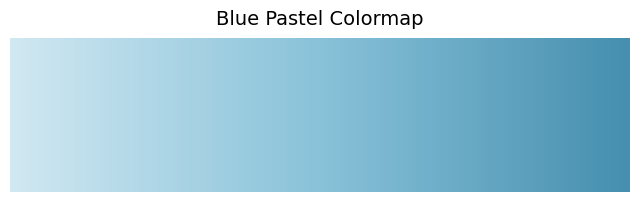

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the custom pastel blue colormap
# blue_pastel_cmap = LinearSegmentedColormap.from_list(
#     "blue_pastel", ["#D0E8F2", "#A9D6E5", "#89C2D9", "#61A5C2", "#468FAF"]
# )

cmap = cm.get_cmap("Blues")  # Color map for activation intensity

blue_pastel_cmap = LinearSegmentedColormap.from_list(
    "blue_pastel", ["#D0E8F2", "#89C2D9","#468FAF"]
)

# Create a gradient to visualize the colormap
gradient = np.linspace(0, 1, 256).reshape(1, -1)

# Display the colormap
plt.figure(figsize=(8, 2))
plt.imshow(gradient, aspect='auto', cmap=blue_pastel_cmap)
plt.axis('off')  # Remove axes for better visualization
plt.title("Blue Pastel Colormap", fontsize=14, pad=10)
plt.show()

